# Comparing Total Gas Masses Between Analyses - XXL-100-GC

This notebook measures gas masses for the XXL-100-GC sample, then compares them to the measurements from literature. While the focus of this work is the measurement of total galaxy cluster masses, comparing measured gas masses gives us an avenue to probe how similar our measurements of the baryon density of the clusters are to those from literature. Seeing as knowledge of the gas density profile feeds into the total gas mass, its important to know if we are consistent.

## Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, UnitConversionError, Unit
from astropy.cosmology import LambdaCDM, WMAP9
import matplotlib.pyplot as plt
from typing import Union, List
from shutil import rmtree
import os
from tqdm import tqdm

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import xxlgc100_colour, xxl_cosmo, direct_comparison_plot, find_lims, fit_comp

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 100
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.imagetools.psf import rl_psf
from xga.sourcetools.density import inv_abel_fitted_model, ann_spectra_apec_norm
from xga.models import BetaProfile1D, DoubleBetaProfile1D, KingProfile1D, SimpleVikhlininDensity1D
from xga.exceptions import ModelNotAssociatedError
from xga.xspec import single_temp_apec

## Reading in Sample Files and Declaring XGA ClusterSamples

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

In [2]:
xxlgc100 = pd.read_csv("../../sample_files/xxl_gc100.csv")

# Limit the comparison to clusters with a flag of 0 - meaning it is in the main sample of 100 clusters
xxlgc100 = xxlgc100[xxlgc100['Flag'] == 0]

# Excluding a specific cluster which was excluded in the XXL analysis
xxlgc100 = xxlgc100[xxlgc100['XLSSC'] != 504]

In [3]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = xxlgc100['ra'].values
dec = xxlgc100['dec'].values
z = xxlgc100['z'].values
n = xxlgc100['name'].values
r500 = Quantity(xxlgc100['r500MT'].values, 'Mpc')

# Declaring the actual ClusterSample instance for the XXL sample
# This is the only sample whose original analysis used the WMAP9 cosmology
xxl_srcs = ClusterSample(ra, dec, z, n, r500=r500, cosmology=xxl_cosmo, load_fits=True, use_peak=False, 
                         clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Setting up Galaxy Clusters:   0%|                                                      | 0/99 [00:00<?, ?it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-94 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:   1%|▍                                             | 1/99 [00:05<08:14,  5.04s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-96 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:   2%|▉                                             | 2/99 [00:12<10:30,  6.50s/it]/mnt/pact/dt23

Setting up Galaxy Clusters:  17%|███████▋                                     | 17/99 [01:19<05:23,  3.94s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-98 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  18%|████████▏                                    | 18/99 [01:23<05:01,  3.73s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-99 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  19%|████████▋                                    | 19/99 [01:26<04:52,  3.66s/it]/mnt/pact/dt23

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-25 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  34%|███████████████▍                             | 34/99 [04:15<17:26, 16.11s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-41 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  35%|███████████████▉                             | 35/99 [04:40<20:13, 18.96s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-50 has not been detected in all regi

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-104 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  47%|█████████████████████▎                       | 47/99 [06:52<07:55,  9.14s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-88 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  48%|█████████████████████▊                       | 48/99 [06:59<07:23,  8.70s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-87 has not been detected in all reg

Setting up Galaxy Clusters:  64%|████████████████████████████▋                | 63/99 [07:53<01:15,  2.11s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-534 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  65%|█████████████████████████████                | 64/99 [07:55<01:16,  2.19s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-517 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  66%|█████████████████████████████▌               | 65/99 [07:58<01:22,  2.42s/it]/mnt/pact/dt

Setting up Galaxy Clusters:  80%|███████████████████████████████████▉         | 79/99 [08:42<00:54,  2.70s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-512 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  81%|████████████████████████████████████▎        | 80/99 [08:46<00:57,  3.03s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-520 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  82%|████████████████████████████████████▊        | 81/99 [08:48<00:47,  2.64s/it]/mnt/pact/dt

Setting up Galaxy Clusters:  98%|████████████████████████████████████████████ | 97/99 [09:48<00:08,  4.08s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-510 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  99%|████████████████████████████████████████████▌| 98/99 [09:51<00:03,  3.62s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-511 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters: 100%|█████████████████████████████████████████████| 99/99 [09:52<00:00,  5.99s/it]


## Running PSF Correction

In [4]:
rl_psf(xxl_srcs)

Generating products of type(s) image: 100%|███████████████████████████████████| 97/97 [00:09<00:00, 10.22it/s]


## Reading in literature data

### Gas masses from literature

In [5]:
xxl_lit_gms = [xxlgc100[xxlgc100['name'] == n].iloc[0][['mg500', 'mg500_err']].values*1e+13 
               for n in xxl_srcs.names]
xxl_lit_gms = Quantity(xxl_lit_gms, 'Msun')

### Conversion Temperatures

In [6]:
xxl_conv_txs = []

for src in xxl_srcs:
    xxl_conv_txs.append(xxlgc100[xxlgc100['name'] == src.name].iloc[0]['T300kpc'])
    
xxl_conv_txs = Quantity(xxl_conv_txs, 'keV')

## Gas Density Profile Generation and Comparison to Literature - from $S_{B}$ Profiles

### Beta and King Profiles - out to 1.3$R_{500}$

In [7]:
demo_sb_mod = BetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═════════════════╤═════════════════════════════════════════════════════════════════════════════╕
│ Beta Profile    │                                                                             │
╞═════════════════╪═════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES       │ Surface Brightness                                                          │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ UNIT            │ ct / (arcmin2 s)                                                            │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS      │ beta, r_core, norm                                                          │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS │ , kpc, ct / (arcmin2 s)                                                     │
├─────────────────┼─

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [8]:
xxl_beta_13_dp = inv_abel_fitted_model(xxl_srcs, 'beta', 'mcmc', xxl_srcs.r500*1.3, 
                                       conv_temp=xxl_conv_txs, conv_outer_radius=Quantity(300, 'kpc'))

Running XSPEC Simulations: 100%|██████████████████████████████████████████████| 97/97 [00:22<00:00,  4.32it/s]
Fitting data, inverse Abel transforming, and measuring densities:  14%|█      | 14/97 [04:49<28:56, 20.93s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-84's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  32%|██▏    | 31/97 [10:59<24:12, 22.01s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 417.73510951  696.90960473 1413.36693528]


Fitting data, inverse Abel transforming, and measuring densities:  37%|██▌    | 36/97 [12:58<23:28, 23.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 184.92153736 1343.13162485 1282.30589903]


Fitting data, inverse Abel transforming, and measuring densities:  45%|███▏   | 44/97 [15:54<18:52, 21.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 242.07535846  837.87697623 1235.50308788]


Fitting data, inverse Abel transforming, and measuring densities:  62%|████▎  | 60/97 [21:40<13:24, 21.74s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-531's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  90%|██████▎| 87/97 [31:10<03:26, 20.63s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/

In [9]:
demo_d_mod = KingProfile1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒═════════════════╤═════════════════════════════════════════════════════════════════════════╕
│ King Profile    │                                                                         │
╞═════════════════╪═════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES       │ Gas Density                                                             │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ UNIT            │ 1 / cm3                                                                 │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS      │ beta, r_core, norm                                                      │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS │ , kpc, 1 / cm3                                                          │
├─────────────────┼─────────────────────────────────────────

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [10]:
with tqdm(desc="Fitting density model to XXL profiles", total=len(xxl_beta_13_dp)) as onwards:
    for dp in xxl_beta_13_dp:
        if dp is not None:
            dp.fit('king', progress_bar=False)
        onwards.update(1)


Fitting density model to XXL profiles:  33%|███████████▏                      | 32/97 [16:16<36:14, 33.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 490.06198249 2427.8952233  2460.68930025]


Fitting density model to XXL profiles:  37%|████████████▌                     | 36/97 [18:27<33:36, 33.05s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1010: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:810: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"
Fitting density model to XXL profiles:  84%|████████████████████████████▍     | 81/97 [41:42<08:20, 31.28s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 308.79511224 1180.83073206  954.36844526]


Fitting density model to XXL profiles: 100%|██████████████████████████████████| 97/97 [49:28<00:00, 30.60s/it]


In [11]:
xxl_beta_king_13_gm = []
with tqdm(desc="Calculating XXL gas masses", total=len(xxl_beta_13_dp)) as onwards:
    for dp in xxl_beta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("king", xxl_srcs[dp.src_name].r500)[0]
            xxl_beta_king_13_gm.append(gm)
        else:
            xxl_beta_king_13_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)
        
xxl_beta_king_13_gm = Quantity(xxl_beta_king_13_gm, 'Msun')

Calculating XXL gas masses:  37%|████████████████▋                            | 36/97 [00:38<01:15,  1.23s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/models/base.py:467: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral_res[par_ind] = 4 * np.pi * quad(integrand, inner_radius.value, outer_radius.value,
Calculating XXL gas masses: 100%|█████████████████████████████████████████████| 97/97 [01:53<00:00,  1.17s/it]


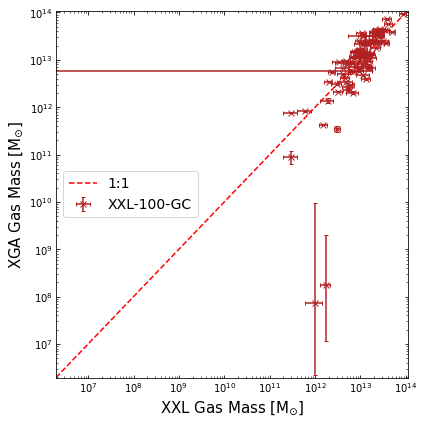

In [12]:
# Setting the y-position and font size of the a, b, and c labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 3 columns, meaning three subplots
fig, ax = plt.subplots(ncols=1, figsize=(6, 6))

ax.minorticks_on()
ax.tick_params(which='both', top=True, right=True, direction='in')
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
xxl_lims = find_lims(xxl_lit_gms, xxl_beta_king_13_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(xxl_lims, xxl_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(xxl_lit_gms[:, 0].value, xxl_beta_king_13_gm[:, 0].value, xerr=xxl_lit_gms[:, 1].value, 
             yerr=xxl_beta_king_13_gm[:, 1:].T.value, fmt='x', 
             color=xxlgc100_colour, capsize=2, label="XXL-100-GC")

# # Labelling axes, setting labels etc.
ax.set_xlabel(r"XXL Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(xxl_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(xxl_lims)

ax.set_xscale('log')
ax.set_yscale('log')


ax.legend(loc='best', fontsize=14)

# Saving and plotting the resulting figure
plt.tight_layout()
# plt.savefig("non_paper_figures/xxl_beta_king_1.3r500_gm_comp.pdf")
plt.show()
plt.close('all')

### Double Beta and Simplified Vikhlinin Profiles - out to 1.3$R_{500}$

In [13]:
demo_sb_mod = DoubleBetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═══════════════════════╤════════════════════════════════════════════════════════════════════════════╕
│ Double Beta Profile   │                                                                            │
╞═══════════════════════╪════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES             │ Surface Brightness                                                         │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ UNIT                  │ ct / (arcmin2 s)                                                           │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS            │ beta_one, r_core_one, norm_one, beta_two, r_core_two, norm_two             │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS       │ , kpc, ct / (arcmin2 s), , kpc, ct / (arcmin2 s

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [14]:
xxl_dblbeta_13_dp = inv_abel_fitted_model(xxl_srcs, 'double_beta', 'mcmc', xxl_srcs.r500*1.3, 
                                       conv_temp=xxl_conv_txs, conv_outer_radius=Quantity(300, 'kpc'))

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Fitting data, inverse Abel transforming, and measuring densities:   1%|        | 1/97 [00:20<32:03, 20.04s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [338.01002295 518.38056305 690.22805329 303.7788864  890.87273517
 740.15534176]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-96's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   2%|▏       | 2/97 [00:41<33:12, 20.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 319.46278231  554.10215813 1236.86128217  265.06383952  428.37598208
 1049.53143408]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-102's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   3%|▏       | 3/97 [01:02<32:35, 20.80s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 281.84174406  383.49308277 1780.39054541  224.77486702  266.63215103
 1422.93571569]


Fitting data, inverse Abel transforming, and measuring densities:   4%|▎       | 4/97 [01:24<33:10, 21.41s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 311.03605486 1036.76569882 1685.11263418  570.73546493  679.94537512
 1489.83881882]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-107's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   5%|▍       | 5/97 [01:45<32:22, 21.12s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 419.70329048 1033.78952989 1234.75706768  271.64674942  419.30097439
 1175.93391911]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-100's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   6%|▍       | 6/97 [02:05<31:22, 20.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 605.85623616 1272.2463273  1041.7186109   657.18303816 1070.46994929
  939.38613336]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-93's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   7%|▌       | 7/97 [02:26<31:20, 20.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 324.79896994  765.13908968 1206.80493753  452.85791255  938.17879167
 1058.43894237]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-108's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   8%|▋       | 8/97 [02:47<31:03, 20.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 450.97514825 1974.58427339 2183.57548034  180.59524324  271.3393358
 1832.71990041]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-95's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   9%|▋       | 9/97 [03:07<30:15, 20.64s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [544.2400404  509.65879465 686.54953783 502.62349209 996.0113155
 810.76385824]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-92's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  10%|▋      | 10/97 [03:27<29:54, 20.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 539.17949079 1321.23246136 1996.1914635   184.84425413  365.87316892
 1665.29121332]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-101's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  11%|▊      | 11/97 [03:48<29:27, 20.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [428.57967441 958.65470988 664.06725356 477.0871652  644.44375107
 568.36809835]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-109's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  12%|▊      | 12/97 [04:08<28:59, 20.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [303.97738346 572.42087797 619.07642648 271.367691   543.27158401
 593.55044739]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-112's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  13%|▉      | 13/97 [04:31<29:49, 21.31s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 434.99205641 1793.88123324 2276.4950669   287.95346099  433.2546968
 2170.1836988 ]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-83's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  14%|█      | 14/97 [04:52<29:22, 21.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 313.4335967  1126.45402634  938.04679796  349.59911667  768.35020669
  802.66551724]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-84's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  15%|█      | 15/97 [05:13<28:36, 20.93s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 443.42855855  583.11405267 2241.10405019  631.96132921  704.82885269
  683.5601568 ]


Fitting data, inverse Abel transforming, and measuring densities:  16%|█▏     | 16/97 [05:34<28:20, 20.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 299.4941656  1019.57650145 1286.40137563  221.80377548  487.16527841
 1184.27375813]


Fitting data, inverse Abel transforming, and measuring densities:  18%|█▏     | 17/97 [05:58<29:06, 21.83s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 281.30137832  750.10481393 1684.67979207 1265.93847463  745.92551095
  868.61594466]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-98's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  19%|█▎     | 18/97 [06:20<29:05, 22.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 474.29354966  513.09157644 1356.12385524 1169.08358164  880.35487702
  708.14948705]


Fitting data, inverse Abel transforming, and measuring densities:  20%|█▎     | 19/97 [06:42<28:28, 21.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [396.13754758 483.98804701 413.11355272 422.32031285 587.19201783
 476.92874588]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-97's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  21%|█▍     | 20/97 [07:02<27:29, 21.42s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 798.0620236  1120.62142704 1446.84654116  800.64648892 1079.6406549
 1389.74012425]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-110's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  22%|█▌     | 21/97 [07:23<27:07, 21.42s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [268.1230963  332.16587401 464.02731721 245.78974382 327.16299985
 447.99679412]


Fitting data, inverse Abel transforming, and measuring densities:  23%|█▌     | 22/97 [07:51<29:03, 23.25s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-72's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  24%|█▋     | 23/97 [08:13<28:12, 22.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 488.50283097  647.99689128 1327.19905138  966.98017076 1200.06567915
 1199.4742485 ]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-56's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  25%|█▋     | 24/97 [08:35<27:31, 22.62s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 825.11076779 1164.09198203 1843.06629505  190.74558312  244.54092253
 1741.60206003]


Fitting data, inverse Abel transforming, and measuring densities:  26%|█▊     | 25/97 [09:00<28:07, 23.43s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-23's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  27%|█▉     | 26/97 [09:21<26:39, 22.53s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [330.74373386 666.99189722 549.79414229 461.78879695 682.43370272
 672.03033342]


Fitting data, inverse Abel transforming, and measuring densities:  28%|█▉     | 27/97 [09:44<26:34, 22.78s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 567.10968155 1409.81989937 2183.76123036 1738.53263203 2022.74896974
 2267.73556799]


Fitting data, inverse Abel transforming, and measuring densities:  29%|██     | 28/97 [10:05<25:38, 22.29s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 983.89549815 1307.5864476  1428.13071628  991.28037447  963.85577162
 1356.68020533]


Fitting data, inverse Abel transforming, and measuring densities:  30%|██     | 29/97 [10:27<25:12, 22.24s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 981.40643229 1427.56069132 1392.20990554 1360.11397605 1537.45929835
 1820.92542654]


Fitting data, inverse Abel transforming, and measuring densities:  32%|██▏    | 31/97 [11:15<25:14, 22.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 336.22041243  702.77911058 1743.15260722 1247.84561817 1365.62382437
 1201.93463859]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1845.37070774 1720.07766863 1692.45962915  541.90433035  608.54529779
  896.6837407 ]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-54's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  34%|██▍    | 33/97 [12:08<26:25, 24.78s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 414.11809591  410.93653546 1226.74850447  933.86098945  941.92126617
  789.44971625]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 501.77234738 1100.49535426 1567.47469509 1111.32256225 1411.54463389
 1745.6692169 ]


Fitting data, inverse Abel transforming, and measuring densities:  35%|██▍    | 34/97 [12:37<27:05, 25.81s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-50's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  36%|██▌    | 35/97 [12:59<25:43, 24.89s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1825.20935599  962.76197529 1998.21216858 1015.80045268  902.36103878
 1930.23212367]


Fitting data, inverse Abel transforming, and measuring densities:  37%|██▌    | 36/97 [13:22<24:45, 24.35s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 393.40672282 1469.80514488 1940.94714793 1132.727478   1393.58277816
 1769.49764566]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [341.56776834 568.80910789 998.06547945 396.30799092 600.73180625
 724.75067537]


Fitting data, inverse Abel transforming, and measuring densities:  38%|██▋    | 37/97 [13:50<25:23, 25.39s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-52's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  39%|██▋    | 38/97 [14:12<24:03, 24.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 458.59165882 1422.58173297 1942.69320179  723.94700837 1497.95585789
 1855.43357565]


Fitting data, inverse Abel transforming, and measuring densities:  40%|██▊    | 39/97 [14:34<22:44, 23.52s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1042.32277862 2168.99585123 1316.90329211 1894.69796661 1988.58998303
 2010.91877792]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-103's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  41%|██▉    | 40/97 [14:55<21:48, 22.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 294.17917442 1088.8256879  1102.5903524   255.02258192  416.32304816
  818.36251609]


Fitting data, inverse Abel transforming, and measuring densities:  42%|██▉    | 41/97 [15:17<20:53, 22.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 825.11901788 1366.50568783 1347.3932797  1096.74565636 1215.55303782
 1445.82916487]


Fitting data, inverse Abel transforming, and measuring densities:  43%|███    | 42/97 [15:40<20:55, 22.83s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 656.1448741   879.5924026   962.845544    926.79795178  938.72188495
 1108.1481276 ]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-27's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  44%|███    | 43/97 [16:03<20:27, 22.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 682.14209825  855.72122407 1556.29107096  231.75303634  427.35482312
 1427.77922362]


Fitting data, inverse Abel transforming, and measuring densities:  45%|███▏   | 44/97 [16:23<19:23, 21.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 633.98496967  738.59323297 1136.83384277  490.26013793  974.18196768
 1268.75897999]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-89's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  46%|███▏   | 45/97 [16:43<18:31, 21.38s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [241.2005412  442.31674901 600.33567696 255.78605105 490.72370678
 507.99177151]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-104's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  47%|███▎   | 46/97 [17:05<18:19, 21.56s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 900.53173194 1754.55646799 2050.91090069  238.5064552   321.92767919
 1975.16184636]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-88's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  48%|███▍   | 47/97 [17:26<17:43, 21.27s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 312.61542821 1420.79155444 1220.88164708  347.74013858 1417.42069222
 1118.06492396]


Fitting data, inverse Abel transforming, and measuring densities:  49%|███▍   | 48/97 [17:50<18:15, 22.35s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 272.53643784  520.08195269 1399.57264172 1282.55098166 1411.8279221
  309.13220984]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [240.129898   692.92603676 396.25134714 445.42293941 540.56372449
 513.57745814]


Fitting data, inverse Abel transforming, and measuring densities:  52%|███▌   | 50/97 [18:40<18:19, 23.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 301.05980062 1395.6454282   435.09981647 1148.47107406 1280.19350112
 1218.31639095]


Fitting data, inverse Abel transforming, and measuring densities:  54%|███▊   | 52/97 [19:28<17:46, 23.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [413.67701592 495.70484035 724.30660957 574.38449338 665.19735458
 849.13822397]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-501's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  55%|███▊   | 53/97 [19:49<16:49, 22.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 369.79404024  670.52558865 1187.12827297  526.87763591  770.01827934
 1085.39891985]


Fitting data, inverse Abel transforming, and measuring densities:  56%|███▉   | 54/97 [20:12<16:27, 22.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 263.28600702 1015.13809292  599.22711149  239.46047998  277.30352348
  484.38256005]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-525's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  57%|███▉   | 55/97 [20:33<15:43, 22.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 511.23688925  895.89507197 1759.70323597  860.81127674 1441.22701373
 1675.26568153]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-528's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  58%|████   | 56/97 [20:54<14:59, 21.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [467.50095006 994.45011917 740.31536652 321.5982985  523.50064313
 799.84383236]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-529's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  59%|████   | 57/97 [21:14<14:17, 21.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 459.49896031  729.30275879 1329.76644154  271.24196242  336.57505473
 1233.22040134]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-526's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  60%|████▏  | 58/97 [21:35<13:52, 21.35s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1162.23971886 1434.67541872 1634.71373163  258.61807589  419.6892497
 1550.11125021]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [253.27840665 401.39810743 855.79977273 241.3664421  213.61229804
 236.07592653]


Fitting data, inverse Abel transforming, and measuring densities:  61%|████▎  | 59/97 [22:02<14:37, 23.10s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-518's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  62%|████▎  | 60/97 [22:22<13:39, 22.15s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 553.51837929  961.9108316  1223.69088785  456.15551084  888.16940944
 1220.20718387]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-531's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  63%|████▍  | 61/97 [22:42<12:50, 21.41s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [455.78424683 730.46651799 858.84241268 505.06343557 628.2798336
 696.34108417]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-534's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  64%|████▍  | 62/97 [23:02<12:15, 21.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 445.38478542  918.6127525  1182.27814466  255.69463444  389.38671772
 1042.38527132]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-517's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  65%|████▌  | 63/97 [23:22<11:42, 20.66s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [330.18719861 489.98656879 444.39577007 440.39608316 587.7185151
 570.52130948]


Fitting data, inverse Abel transforming, and measuring densities:  66%|████▌  | 64/97 [23:42<11:17, 20.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [557.32317725 866.11815567 624.79505325 505.70439134 578.26245075
 554.69610688]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-503's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  67%|████▋  | 65/97 [24:03<10:58, 20.59s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 543.91492245 1218.79706596 1858.31050973  694.43924595 1500.26137447
 1646.30840535]


Fitting data, inverse Abel transforming, and measuring densities:  68%|████▊  | 66/97 [24:23<10:35, 20.48s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [273.19012172 698.84790466 683.37600676 256.51867729 642.40374454
 529.57479385]


Fitting data, inverse Abel transforming, and measuring densities:  69%|████▊  | 67/97 [24:47<10:43, 21.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 178.83398346  299.98478828 1611.47392968 1214.87470695  925.362187
  154.38139134]


Fitting data, inverse Abel transforming, and measuring densities:  70%|████▉  | 68/97 [25:12<10:53, 22.53s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-547's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  71%|████▉  | 69/97 [25:33<10:15, 22.00s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [371.28199245 582.95017963 454.24786345 399.86972425 509.3739944
 552.03947028]


Fitting data, inverse Abel transforming, and measuring densities:  72%|█████  | 70/97 [25:54<09:50, 21.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1279.97687232 1343.88708351 1572.45787318 1335.76969312 1248.88683109
 1625.66330058]


Fitting data, inverse Abel transforming, and measuring densities:  73%|█████  | 71/97 [26:15<09:17, 21.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 445.16044598  910.1989951  1053.19443014  427.57488179  706.54415557
  625.19789005]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-522's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  74%|█████▏ | 72/97 [26:36<08:53, 21.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 376.08264752 1462.46959974 1560.95014583  381.96535991  551.94950954
 1501.7701961 ]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 970.58661437 1001.85471441 1352.9509585   605.12008762  754.99554317
 1321.37113033]


Fitting data, inverse Abel transforming, and measuring densities:  76%|█████▎ | 74/97 [27:22<08:28, 22.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 380.64099602  580.59383209 1303.38258165  886.6013972   714.97282385
  920.74501484]


Fitting data, inverse Abel transforming, and measuring densities:  77%|█████▍ | 75/97 [27:52<08:58, 24.49s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-506's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  78%|█████▍ | 76/97 [28:12<08:09, 23.31s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 394.98006137 1053.06108329 1226.64699161  284.38247959  323.37884989
 1100.79908375]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-546's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  79%|█████▌ | 77/97 [28:32<07:27, 22.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 598.30015161  685.99003735 1106.05406125  396.27891996  604.57686876
  904.08802773]


Fitting data, inverse Abel transforming, and measuring densities:  80%|█████▋ | 78/97 [28:54<07:01, 22.17s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 325.70696081  486.37202596 1188.00772957  255.79693228  376.36381959
 1039.20071584]


Fitting data, inverse Abel transforming, and measuring densities:  81%|█████▋ | 79/97 [29:18<06:50, 22.83s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-532's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  82%|█████▊ | 80/97 [29:39<06:15, 22.07s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [375.65569986 658.75604279 626.25399676 314.42341106 475.07899233
 431.35104554]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-519's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  84%|█████▊ | 81/97 [30:00<05:48, 21.78s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [454.86430283 417.42983098 889.60998339 552.77042505 524.36290157
 379.04218331]


Fitting data, inverse Abel transforming, and measuring densities:  85%|█████▉ | 82/97 [30:21<05:22, 21.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 356.54023157 1007.52038256  878.62545077  356.69428989  850.75847324
  532.22886995]


Fitting data, inverse Abel transforming, and measuring densities:  86%|█████▉ | 83/97 [30:47<05:21, 22.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [613.53596007 486.31542915 480.66448943 397.97521775 427.14692023
 529.30369349]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-507's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  87%|██████ | 84/97 [31:06<04:42, 21.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [432.42674513 621.74465532 542.13980272 478.82904688 698.10813935
 588.79218893]


Fitting data, inverse Abel transforming, and measuring densities:  88%|██████▏| 85/97 [31:28<04:21, 21.81s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [333.44010269 604.9567681  359.79118924 592.55765255 671.12604147
 357.11835367]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-516's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  89%|██████▏| 86/97 [31:48<03:53, 21.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 629.95019411  762.29768264 1424.42699198  659.17590356  728.37336395
 1455.98141517]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-537's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  90%|██████▎| 87/97 [32:09<03:31, 21.12s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 332.24787265  842.58530909 1036.67384415  277.36513124  481.88614842
 1018.34803615]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-548's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  91%|██████▎| 88/97 [32:29<03:07, 20.79s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 287.72322628  500.4113475  1601.56869355  256.17233939  390.41291046
 1283.37276744]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-538's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  92%|██████▍| 89/97 [32:49<02:45, 20.70s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 312.30701816 1003.68270767 1576.56804959  420.0391145   824.91099585
 1339.03548367]


Fitting data, inverse Abel transforming, and measuring densities:  93%|██████▍| 90/97 [33:12<02:30, 21.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [190.7863768  192.49277784 579.62655409 415.48692603 232.0791989
 213.78478946]


Fitting data, inverse Abel transforming, and measuring densities:  94%|██████▌| 91/97 [33:36<02:12, 22.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [549.36625664 457.09032961 506.87233848 745.30314864 711.06565719
 679.75982647]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-508's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  95%|██████▋| 92/97 [33:57<01:49, 21.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 698.33842242  286.20001808 1457.73267981  269.0261436   287.74067664
 1342.2019451 ]


Fitting data, inverse Abel transforming, and measuring densities:  96%|██████▋| 93/97 [34:18<01:25, 21.50s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 399.77460955 1069.94142905 1267.01382723  423.45000181  842.78314643
 1249.59192548]


Fitting data, inverse Abel transforming, and measuring densities:  97%|██████▊| 94/97 [34:38<01:03, 21.20s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 480.36363151  805.37905163  934.72146202  337.55448615  886.78166863
 1065.36814336]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-509's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  98%|██████▊| 95/97 [34:58<00:41, 20.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 959.27781329 1952.17806884 1455.89804708  559.017086   1389.99906409
 1486.72623366]


Fitting data, inverse Abel transforming, and measuring densities:  99%|██████▉| 96/97 [35:19<00:20, 20.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [290.79103273 433.22354887 678.19221177 271.76962124 545.7330931
 656.18283938]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 97/97 [35:41<00:00, 22.07s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 478.5407889  1255.35349903 1211.9457953   620.97656436  785.13328843
  700.64679816]


In [15]:
demo_d_mod = SimpleVikhlininDensity1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒════════════════════════════════╤═══════════════════════════════════════════════════════════════════════╕
│ Simplified Vikhlinin Profile   │                                                                       │
╞════════════════════════════════╪═══════════════════════════════════════════════════════════════════════╡
│ DESCRIBES                      │ Gas Density                                                           │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ UNIT                           │ 1 / cm3                                                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETERS                     │ beta, r_core, alpha, r_s, epsilon, norm                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS                │ , 

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 5.]>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [16]:
with tqdm(desc="Fitting density model to XXL profiles", total=len(xxl_dblbeta_13_dp)) as onwards:
    for dp in xxl_dblbeta_13_dp:
        if dp is not None:
            dp.fit('simple_vikhlinin_dens', progress_bar=False)
        onwards.update(1)

Fitting density model to XXL profiles:   1%|▎                                  | 1/97 [00:32<52:34, 32.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 664.44330973 1468.28924243  627.1265845   993.91469625  451.5828043
 1060.16565714]


Fitting density model to XXL profiles:   4%|█▍                                 | 4/97 [01:10<25:34, 16.50s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [461.0703354  584.75858336 282.77048169 650.1896452  388.69486047
 287.78832892]


Fitting density model to XXL profiles:  16%|█████▌                            | 16/97 [01:45<07:11,  5.33s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1215.909281   1937.67234866  474.19795145 1678.17478171  871.64142953
  959.40997776]


Fitting density model to XXL profiles:  18%|█████▉                            | 17/97 [02:34<12:16,  9.20s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 154.33175024  243.15266393 1224.29151848  129.90078202  130.39242026
  424.10217516]


Fitting density model to XXL profiles:  20%|██████▋                           | 19/97 [03:11<14:20, 11.04s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 705.03949421 1407.64418778  572.88384035 1041.6935171   433.49621698
  669.55602026]


Fitting density model to XXL profiles:  23%|███████▋                          | 22/97 [04:04<16:20, 13.08s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 773.99838723 1513.89603087 1117.48607254 1248.93101009 1118.58799046
 1380.18868388]


Fitting density model to XXL profiles:  26%|████████▊                         | 25/97 [04:42<15:35, 12.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 913.85680202 1872.64053275 1548.8054106  1920.10803929 1315.61050817
 1807.5209667 ]


Fitting density model to XXL profiles:  28%|█████████▍                        | 27/97 [05:20<16:39, 14.28s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [530.69935258 203.66452663 216.69539325 707.31334273 570.91832568
 131.44265996]


Fitting density model to XXL profiles:  29%|█████████▊                        | 28/97 [05:56<19:56, 17.35s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 954.07399132 1365.35384923 2792.81485618  664.88300177  308.5507451
 1784.82013243]


Fitting density model to XXL profiles:  30%|██████████▏                       | 29/97 [06:31<22:51, 20.17s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2035.01201223 2304.46254696 2834.98821344 1484.10564804  539.17869667
 2577.81395447]


Fitting density model to XXL profiles:  31%|██████████▌                       | 30/97 [07:12<26:59, 24.17s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 741.99470555 1837.46612691 1126.90285174 1782.15931041  904.19365651
 1730.46505491]


Fitting density model to XXL profiles:  32%|██████████▊                       | 31/97 [07:47<29:03, 26.42s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 397.29637317  477.70953815 2120.65139078  423.13408905  254.63429376
  479.39695925]


Fitting density model to XXL profiles:  35%|███████████▉                      | 34/97 [09:12<29:57, 28.52s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 710.40631054 1360.50679237 1602.59001093  513.59266469  284.14556383
 1304.47646426]


Fitting density model to XXL profiles:  38%|████████████▉                     | 37/97 [10:38<29:42, 29.71s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 507.39603548 2896.91556097  711.04378693  551.11754668  511.8621304
 2895.22042671]


Fitting density model to XXL profiles:  40%|█████████████▋                    | 39/97 [11:16<24:42, 25.56s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 613.74626164 1519.52463084  894.1245321   909.72770375  491.64838917
 1351.70744922]


Fitting density model to XXL profiles:  42%|██████████████▎                   | 41/97 [11:51<21:13, 22.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2632.36202947 3135.62309472 3656.42771634 2009.81776061  921.91218878
 3467.02103512]


Fitting density model to XXL profiles:  43%|██████████████▋                   | 42/97 [12:31<24:00, 26.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [593.76091069 658.81792098 922.47345887 507.11076844 206.67966842
 778.97129646]


Fitting density model to XXL profiles:  45%|███████████████▍                  | 44/97 [13:03<19:48, 22.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 657.70217651 1897.94870491 1000.44544567  653.37744133  573.27596135
 1735.19134838]


Fitting density model to XXL profiles:  51%|█████████████████▏                | 49/97 [14:33<16:58, 21.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1270.17157716 1528.91648919 1529.85968339 1859.46110668 1074.03401862
 1648.61995869]


Fitting density model to XXL profiles:  53%|█████████████████▉                | 51/97 [15:50<20:53, 27.24s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2832.24838172 2968.97922377 3147.17616024 2213.88996701 2199.69730118
 3000.92516502]


Fitting density model to XXL profiles:  54%|██████████████████▏               | 52/97 [16:27<22:06, 29.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2776.95374797 3065.32137202 2743.21345038 1951.04415176 1891.72313159
 2967.57643888]


Fitting density model to XXL profiles:  56%|██████████████████▉               | 54/97 [17:04<18:07, 25.29s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [453.13619274 705.21033067 698.1301476  640.32892736 468.42708824
 863.04262718]


Fitting density model to XXL profiles:  61%|████████████████████▋             | 59/97 [17:49<09:58, 15.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [547.68734576 442.86026648 297.7494451  630.28139914 214.08618081
 297.6509985 ]


Fitting density model to XXL profiles:  66%|██████████████████████▍           | 64/97 [18:24<06:29, 11.79s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1548.5230603  1975.73305123 1146.11303384 1291.0478492  1032.58150787
 1751.7543632 ]


Fitting density model to XXL profiles:  68%|███████████████████████▏          | 66/97 [18:59<06:39, 12.89s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 433.61308605 1270.37848869  447.18499523 1062.99717244  538.50386437
  579.33267896]


Fitting density model to XXL profiles:  69%|███████████████████████▍          | 67/97 [19:37<08:06, 16.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 241.74128621  784.35006011 2181.41893749  271.84676443  209.94306265
  860.25628197]


Fitting density model to XXL profiles:  70%|███████████████████████▊          | 68/97 [20:18<09:38, 19.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 431.93250541 1200.93163141  840.96717386  917.25285549  552.47109667
 1073.54983795]


Fitting density model to XXL profiles:  72%|████████████████████████▌         | 70/97 [20:58<08:58, 19.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1566.7166321  1851.28484683 2129.50795651 1058.88560746  488.28663823
 1981.19134815]


Fitting density model to XXL profiles:  73%|████████████████████████▉         | 71/97 [21:35<10:00, 23.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 649.60973371 1062.92059257  711.0869699   828.06464168  396.47413487
  854.86525142]


Fitting density model to XXL profiles:  75%|█████████████████████████▌        | 73/97 [22:17<08:59, 22.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1119.50176954  968.56632768  351.73555586  783.49317415  371.18181673
  452.48336785]


Fitting density model to XXL profiles:  76%|█████████████████████████▉        | 74/97 [22:54<09:40, 25.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [409.13743758 460.82769674 836.44636633 425.93671706 194.12550588
 541.75600868]


Fitting density model to XXL profiles:  80%|███████████████████████████▎      | 78/97 [24:22<06:55, 21.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 500.29620942 1273.55012467  259.39646365  942.66989421  260.24051305
  519.57264495]


Fitting density model to XXL profiles:  81%|███████████████████████████▋      | 79/97 [25:01<07:31, 25.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 931.91532687 2376.18697314  849.39455624 1692.92387735  796.80438319
 1540.56633773]


Fitting density model to XXL profiles:  85%|████████████████████████████▋     | 82/97 [25:38<04:50, 19.37s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 640.76302372 1238.71022991  642.58705204 1049.96931491  461.20970474
  752.14230179]


Fitting density model to XXL profiles:  88%|█████████████████████████████▊    | 85/97 [26:54<04:14, 21.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 895.45198981 1807.34762017 1079.35306225 1721.29670284  975.05992626
 1217.45208697]


Fitting density model to XXL profiles:  93%|███████████████████████████████▌  | 90/97 [27:28<01:33, 13.38s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2674.24172195 3067.44320067 3020.41165758 2040.80467126 2168.86334676
 3343.04915825]


Fitting density model to XXL profiles:  94%|███████████████████████████████▉  | 91/97 [28:10<01:43, 17.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2757.43802552 2975.23071338 3223.08221588 2238.3728416   829.57851295
 3049.09218741]


Fitting density model to XXL profiles:  96%|████████████████████████████████▌ | 93/97 [28:45<01:09, 17.34s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [460.11230001 500.56083775 792.39901659 427.30426579 208.70717666
 446.34732747]


Fitting density model to XXL profiles:  97%|████████████████████████████████▉ | 94/97 [29:20<01:00, 20.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 713.6257142   959.69627229  777.67742038  831.47407728  399.78058536
 1028.75750198]


Fitting density model to XXL profiles: 100%|██████████████████████████████████| 97/97 [30:33<00:00, 18.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 597.41665543 1471.36090229  958.56568635 1004.5581446   452.38895447
 1098.35124424]


In [17]:
xxl_dblbeta_svikh_13_gm = []
with tqdm(desc="Calculating XXL gas masses", total=len(xxl_dblbeta_13_dp)) as onwards:
    for dp in xxl_dblbeta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("simple_vikhlinin_dens", xxl_srcs[dp.src_name].r500)[0]
            xxl_dblbeta_svikh_13_gm.append(gm)
        else:
            xxl_dblbeta_svikh_13_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)
        
xxl_dblbeta_svikh_13_gm = Quantity(xxl_dblbeta_svikh_13_gm, 'Msun')

Calculating XXL gas masses:  37%|████████████████▋                            | 36/97 [01:51<04:24,  4.34s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/models/base.py:467: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  integral_res[par_ind] = 4 * np.pi * quad(integrand, inner_radius.value, outer_radius.value,
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/models/base.py:467: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral_res[par_ind] = 4 * np.pi * quad(integrand, inner_radius.value, outer_radius.value,
Calculating XXL gas masses: 100%|█████████████████████████████████████████████| 97/97 [06:43<00:00,  4.16s/it]


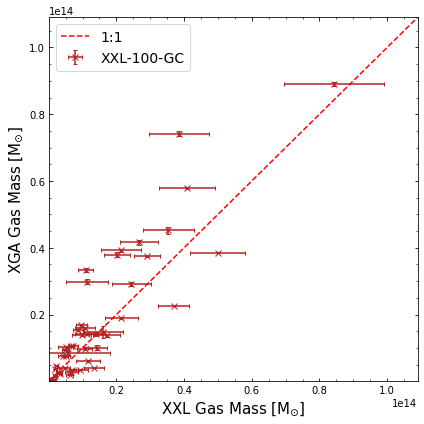

In [18]:
# Setting the y-position and font size of the a, b, and c labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 3 columns, meaning three subplots
fig, ax = plt.subplots(ncols=1, figsize=(6, 6))
ax.minorticks_on()
ax.tick_params(which='both', top=True, right=True, direction='in')
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
xxl_lims = find_lims(xxl_lit_gms, xxl_dblbeta_svikh_13_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(xxl_lims, xxl_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(xxl_lit_gms[:, 0].value, xxl_dblbeta_svikh_13_gm[:, 0].value, xerr=xxl_lit_gms[:, 1].value, 
             yerr=xxl_dblbeta_svikh_13_gm[:, 1:].T.value, fmt='x', 
             color=xxlgc100_colour, capsize=2, label="XXL-100-GC")

# # Labelling axes, setting labels etc.
ax.set_xlabel(r"XXL Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(xxl_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(xxl_lims)

ax.legend(loc='best', fontsize=14)

# Saving and plotting the resulting figure
plt.tight_layout()
# plt.savefig("non_paper_figures/xxl_dblbeta_svikh_1.3r500_gm_comp.pdf")
plt.show()
plt.close('all')